# 11 Advanced Computer Vision Applications continued 
![](https://drive.google.com/uc?id=1cbE342r_rUhoqnL6fzlpGsVqI7QHhbOn)

> Before Starting, we will change the accelerator of this notebook from a CPU to a GPU, since we'll be running our Neural Networks on the GPU. 

> Go to Runtime --> Change Runtime Type --> GPU 


Welcome to the 11th session in the Practical Machine Learning. In this session, we will continue our exploration in Computer Vision. 

Till now we've seen a few Computer Vision applications, like Image Classifiers, Segmentation Models and Object Localizer Systems. But as we mentioned, computer vision is such an expansive field, with such expansive applications, that researchers have come up with endless way to apply Deep Learning for Computer Vision. 

As we reach towards the end of our discussion on Computer Vision, here is a wonderful insight for you. 

The broad task of any Computer Vision system is the same - to recognize what is going on in an image/sequence of images. The only thing that varies is the way in which the objects in the image(s) are recognized. 

For example, in a simple CNN based Image Classifier, the image is processed as a whole to categorize an image into one of the predefined classes (like a cat, or a dog, etc.).

In a segmentation model, the analysis is carried out over each individual pixel of the image, and each pixel is classified into one of the predefined categories. Ofcourse each pixel is not independent of others - a single pixel anyways does not make sense. It is a group of pixels that make logical and spatial sense. (For example, a single pixel is meaningless, but a group of pixels forms the eye, or the chin, and groups of these groups forms higher level objects like entire faces, and so on). But still the segmentation model holds the power to differentiate between two adjacent pixels at the very minute level. 

In a bounding box prediction model, the model predicted a box, in which it was most likely that the object of our interest lay. 

There are many more ways in Computer Vision to identify objects. For example, there are models that predict certain key points on a person's body, which can be connected later to form a skeleton. And this skeleton prediction is the method through which objects are detected through this particular method. 

In this session, we'll look at slightly different use cases. We will be studyinng about the *Siamese Network problem*  and *Neural Style Transfer*. Again, the only thing that differs in these problems is the way that objects are recognised in images. 

Let us start by understanding each one of these. Let us also install the necessary libraries that are needed to run this notebook! These particular examples are already present out there.  We will however, explain each component from the perspective of what we already know through this course. 

In [ ]:
!pip install --upgrade fastai >./tmp
from fastai.vision.all import *

In [ ]:
import PIL

## The Siamese Network Problem

The Siamese Network tries to solve an extreme case of Image Classification - the case where we just don't have enough data. 

One of the key reasons Image Classification models are so robust and well generalizable is the sheer amount of data that is available to train them. Companies such as Facebook and Instagram have access to literally 100s of billions of photos to train their models upon. Even the model that we train usually start with a pretrained model that has been trained upon a dataset like ImageNet, which contains 1.4 Million images in total. And to be frank, in a lot of cases, data is not even an issue anymore. Everyone has smartphones with cameras, and tools to make and share content on the Internet, especially visual media (Images, videos, etc.). There is infact, more visual data currently out there, than we know how to utilize properly. 

But what if you do not have enough data? Traditional CNNs do not perform good in those cases. Let's say, for example, you wish to build a face detection system for a company that wishes to use AI for automatically marking the attendance of its employees without them having to manually register their names somewhere. Ideally, it would want to match the face (that is captured in the camera) with the photos in the database. But we don't usually have 100s of photos of each employee! We usually have one photo per employee - the photo they must have registered in the database at the beginning of their jobs! So how do we build a system that can learn to identify you from others, using just such scarce data?

Let us think how the human brain works. Ideally, if you see a picture of someone, and are then asked to recognize the person from a crowd, you will most probably be able to do that, even if you may not have seen a hundred pictures of that person! If our brain can do it, why should AI Systems not be able to do that too?

This is a special domain in AI, called as *Few Shot Learning*. Basically, the task is to make good predictions even when only a few (sometimes one, sometimes even zero! (yes, its possible)) training examples are given. Siamese Networks were one of the first attempt to address this in Computer Vision. 

Let us understand the working principle of a Siamese Network.


### How does a Siamese Network work?

Siamese Networks use a clever technique. Rather than trying to learn features of categories (classes), Siamese Networks try to differentiate between individual instances. So now, the model does not need to identify what a particular person looks like. All it needs to do is to compare the input with a reference image and predict whether or not the image is of the same class/object/person or not. So ultimately our problem is a binary classification problem.

![](https://drive.google.com/uc?id=1pFz7P2zc37Bw6R7t4-Vy4pWDfL-V1y_u)

How do Neural Networks identify what an image is about? It does so using *features*. And how do models derive features, especially in Images? through convolutions! So there is a network in a Siamese Network that derives features in the form of some parameter tensors. And we also learnt that this network, the job of which is to find features, is called an *encoder*. 

Now this encoder would derive features from both images. 

(Note that for a properly trained network, the features are independent of what the image looks like, as long as the image contains the same particular object. Like for the above image, both images contain tigers, and the features of the network that any Image classifier would be related. I am stressing on this point, because you might ask, well, if you really wanted to compare whether or not two images are the same or not, why even use a Neural Network? Why cant you simply compare pixel values? But in that case, images of two persons can only 'match' if the two images are exact copies of each other. Now if you wish to compare the photo in the database, and the photo captured by the camera for the case study that we were discussing, the two photos would most likely not match! So this is why Convolutional Neural Networks are used. Neural Networks ideally are independent of such differences. They try to incorporate the overall spatial nature of images.)

Now our job is to build a system that can identify whether or not these two feature tensors match or not. Basically a binary classifier which predicts - Do these match (Yes! or a 1) or not (No! or a 0).

This is just another Fully Connected Network. We call this the *head* of the model. The original approach involved *concatenating*, or joining the two feature tensors end to end, and using that as an input. 

So, in essence, Siamese Networks are a combination of 2 models, the ultimate job of which is to do a binary classification! Let us see how to build this model. Before starting, we will download the PETS dataset. You can use any dataset really. But for demonstration, this dataset works too! (Even though its not really scarce).



### Setting up the dataset

In [ ]:
path=untar_data(URLs.PETS)
files=get_image_files(path/'images') #get the paths of all images in this dataset
files

In [ ]:
print(files[0].stem)
Image.open(files[0])

Before we even start with formatting our Siamese Network problem, we need to get the basic things right. Like how do we compare two images? We do that using labels. But how do we derive labels? Ofcourse using a labeling function. 

We've already built this function in one of the previous sessions where we used the PETS dataset. It uses something called as an regex expression. You're not expected to memorize this as such. You can always do a quick google search for syntax rules anyways!

In [ ]:
def label_func(f): return re.match(r'^(.*)_\d+.jpg$', f.name).groups()[0]

#lets see if this works. We should be able to get the breed name when a file path is passed
label_func(files[0])

Let us take a look at all the labels that we will be dealing with (Just for visualization!)

In [ ]:
labels = list(set(files.map(label_func)))
labels

In [ ]:
len(labels)

And parallely, for convenience, we will make a dictionary of all files categorized by label. The reason is explained clearly later

In [ ]:
label2files = {l: [f for f in files if label_func(f) == l] for l in labels}

We should also split the dataset into the train and validation set. Let us split the data into a 80/20 split for now.

In [ ]:
idxs = np.random.permutation(range(len(files)))
cut = int(0.8 * len(files))
train_files = files[idxs[:cut]]
valid_files = files[idxs[cut:]]

### Setting up data for Siamese Network
We didn't have to do anything special for normal Image classification models, because they were just one single image. So all we needed to do was to take all these images, and put them in a batch, and feed them into a network (after converting them to tensors).

But now, we need to make some changes. The input is no longer a single image, but a collection of two images, which need to be fed together (in the form of a tuple, lets say). (A tuple, if you remember is like a list, except its not mutable).

So lets build a dataset class that can handle these two images together. Remember that every dataset has 2 important attribute - the `__len__` attribute (to get the length of the dataset) and the `__getitem__` attribute (to retrieve and element from the dataset). (If you don't remember this, go back and revise what a Dataset and a DataLoader are! They are very important concepts!).

The `__len__` attribute will simply return the number of images there are in the dataset. 

The `__getattr__` is slightly tricky. Earlier, we used `__getattr__` to return the input (tensor) and the output (tensor). Now it needs to be input tensor 1, input tensor 2 and the output (a tensor of 0s and 1s (or Falses and Trues, but since computers only understand numbers, they need to be 0s and 1s))

We define a function called as `open_image` which takes a path, and returns the final processed, normalized tensor. (Its nothing! just simple code refactoring)

In [ ]:
#this is a function that takes in an image path, and returns a PyTorch compatible tensor  
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size)) #by default, we will use size 224, which is the standard ResNet presize
    t = torch.Tensor(np.array(img)) # converting the image to a tensor
    return t.permute(2,0,1).float()/255.0  #by default, PIL Images have channel as the last dimension. But PyTorch expects channel to be the first dimension. Also .float()/255. is a standard way to normalize the data

In [ ]:
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files
        
    def __getitem__(self, i):
        file1 = self.files[i]
        (file2,same)= self._draw(file1)
        img1,img2 = open_image(file1),open_image(file2)
        return (img1, img2, torch.Tensor([same]).squeeze())
    
    def __len__(self): return len(self.files)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = label_func(f)
        if not same: cls = random.choice([l for l in labels if l != cls]) 
        return random.choice(label2files[cls]),same

What does `_draw` do? Remember that we need a pair of images? 
So _draw randomly picks a seond image from the file list, and according assigns a label. If the two images are from the same category, the label is `True`, and otherwise false. This is where `label2files` also comes in handy. We pick up the random image file from this dictionary.

So now let us build the training and validation set using the newly created Dataset class.

In [ ]:
train_ds = SiameseDataset(train_files)
valid_ds = SiameseDataset(valid_files)

And as always, once we build datasets, we need to build Dataloaders, which will feed the data into our model.

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds).cuda() # .cuda() feeds the dataloaders to the GPU. We didnt have to do it before, because fastai did it for us. But here we had to define our custom dataset.

Here is what a single batch would look like in the dataloader.

In [ ]:
b=dls.one_batch()
b[0].shape, b[1].shape, b[2]

### The Siamese Model
Now let us come to the final component of the Siamese Network - The model. 

As we mentioned before, the Siamese Model is nothing but a bundle of two models - the encoder and the head (if you don't recall what each one of these does, go back up and read what their job is!). So before defining any functionality, let us first create a class that can handle these two things. 

We can also define the `forward` function, which if you remember is the function that is used to do the forward pass in Pytorch nn.Modules classes. And since our function *inherits* from nn.Module, it will also use `def forward` to do a forward pass.

This forward pass basically passes image 1 through the `encoder`, then passes image 2 through the same `encoder`, concatenates the features into a single tensor, and passes this tensor through the `head` architecture. 

In [ ]:
class SiameseModel(nn.Module):
    def __init__(self,encoder,head):
        super().__init__()
        self.encoder,self.head = encoder,head

    def forward(self,x1,x2): 
        features = torch.cat([self.encoder(x1),self.encoder(x2)],dim=1)
        return self.head(features)

Okay, so all we need to do is define the encoder and the head. Encoder is nothing but a standard CNN that derives features. So let us use ResNets! (Why not?!)

In [ ]:
encoder=create_body(resnet34,cut=-2) # cut basically removes the final layers from the model. Remember, the final layers calculate probabilities, not features, so we dont need them
encoder

Notice that there are 512 features in the final layer, meaning the encoder will output 512 neurons for each image. 

So after concatenation, we will feed a 512*2 = 1024 neuron tensor to the head, and get two neurons and output (corresponding to True or False (0 or 1)) (remember, 0 means, that the model thinks the two images are not from the same category, and 1 means that the model thinks they are!)

In [ ]:
head=create_head(512*2,2,ps=0.5) # 512 because encoder ends with 512 features 
head 

And now that we have defined our encoder and head architectures, let us initialize our model using the `SiameseModel` class that we just defined. 

In [ ]:
model=SiameseModel(encoder,head).cuda()

All we need to do now, is train the model. But before that, we need to tell fastai's Learner class the parameters are not only present in the encoder, but in the head also. So it needs to look simultaneously in two places. So we define a function for that. Its a little complicated, and requires some background explanation. So for now, you can leave it. Don't worry about the following line of code!

In [ ]:
#additional thing
def siamese_splitter(model): return [params(model.encoder), params(model.head)]

Now let us build our Learner (which will train our model). We also need to define the loss function. But as you know, our problem is a simple binary classification problem. So a simple Cross Entropy Loss will work! 

In [ ]:
def loss_func(out,targ): return nn.CrossEntropyLoss()(out,targ.long()) #.long() because targets are integers by default, and GPUs give errors on integers.

In [ ]:
learn = Learner(dls,model,loss_func=loss_func,splitter=siamese_splitter,metrics=accuracy)
learn.freeze()

Let us train this model and see the result ourselves

In [ ]:
learn.fit_one_cycle(4,2e-3)

Almost a 94% accuracy, is a pretty strong result! That's it. That's all it takes to build a Siamese Network. 

Before we jump onto the next section on Style Transfer, let us discuss about the use of Siamese Networks in general. 

Siamese Networks were first introduced in 2012, in [this](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) paper. It is still used in facial detection systems in a lot of institution all around the world. But Siamese Networks are definitely NOT State of the Art. You may have guessed that, since they were proposed almost a decade ago, and a decade in Machine Learning most definitely makes anything obsolete. 

Its not the technique used that makes it inefficient. Infact, it is one of the more sophisticated techniques in Computer Vision. (The fact that you can carry out predictions with very scarce data is amazing). It is one fundamental error in the model design that makes it inefficient. That is, the use of Fully connected layers to do the main task - binary prediction. 

> Quick Question. Why do you think CNNs work better than Fully Connected Neural Networks for Images? Search it up on Google. Its a wonderful insight to gain about Deep Learning in general, and you'll really appreciate it. It will also give you the answer to the above question. 

There are much better one-shot/few-shot/zero-shot learning algorithms present now, that can maintain the spatial distribution of data (this is one of the keys of the answers to the above asked question, Please DO search it up on Google!). 

But still Siamese remains one of the most famous few-shot learning algorithms out there. This is a testament of the fact that a sophisticated and good design need not be incredibly complex. Infact more complex algorithms are more likely to be forgotten fast!

## Neural Style Transfer
Style Transfer is a really niche problem of Computer Vision. The idea is to combine the *styles* of 2 different images, into one. The most famous application of this is making a photo from our everyday lives in the style of a famous artist (like Van Gogh, or Da Vinci, or Monet, or Picasso, or Michelangelo). Take a look at this.
![](https://drive.google.com/uc?id=1sptBT69cDS5TwmUP7OvpfWfiqTznCpa8) 

Its amazing to think that all this was done by AI. We ourselves don't know how exactly such an algorithm can be designed through a procedural workflow, so it still seems like magic, even after many years of its release in the academic world.

Style Transfer has been attempted by many researchers. But we will essentially focus on the work introduced by a group of researchers from Stanford through [this](https://arxiv.org/abs/1603.08155) paper (Try reading the paper!). The reason being that this paper is one of the most influential papers in Deep Learning. It introduced a new type of loss function known as the Perceptual Loss function, and also demonstrated its application in various Computer Vision problems apart from style transfer, like, Super Resolution, which is still a very hot topic in research, and still takes inspiration from the proposed loss function and other techniques.

We'll basically be implementing this paper below, and training a state-of-the-art style transfer model.

So let us see what we will be essentially implementing. 

![](https://drive.google.com/uc?id=19ATk2L27svRaoUgRGDSQ4AJIuywfB0S8)

We will be implementing an *Image Transform Network*, which takes an input image, that we provide to it, and outputs the image with the change in style. We've already seen a model that does this. The UNet Model! The Transformation Network is very similar to the UNet in design. 

Now the task of our overall model is to bring in some elements from the "Style Image" (the image of the famous artist, lets say), while still retaining some elements of the "Content Image" (The image you want to transform to another style). One way to match the similarity of two values is to simply calculate some sort of *loss* value between the two values, that measures the dissimilarity between the two, and try to minimize this loss value. We've seen loss between target and prediction of a Neural Network (we try to make predictions and targets as similar as possible)!. So here, all we need to do is to implement two types of losses - Loss between the output image and the Style Image, and the loss between the output image and Content Image. Our final job is to simply minimize both these losses. You can basically create a new loss function, which is the aggregate of these two loss values, which the authors call, in fancy terms, "Perceptual Loss".

The loss is not calculated for the output of a Neural Network, but for the values of the features from the various layers of another Neural Network in itself (yes, pretty confusing, but quite interesting). We will see the details of how this exactly works step by step.

The authors called this second Neural Network (thorugh which the loss was calculated) the Loss Network. This itself is a Convolutional Neural Network. Think of this as basically any other Neural Network. There's an architecture (the Image Transform Network), to which you feed an input, and get a prediction. You calculate the loss between the target and the prediction. Just that, here, the loss is not a simple math function (like the Cross Entropy loss), but uses an entire Neural Network in itself. The authors used a variant of CNN, called as the VGG Network. So let us implement that first.

In [ ]:
!pip install --upgrade fastai >./tmp
from fastai.vision.all import *

### The Loss Network
We will implement this model over a vgg16 and vgg19 model. However, for the purpose of implementation, we will be using mostly the vgg16 architecture, because of the lesser number of parameters. vgg19 may cause a CUDA Out of memory error. But feel free to try it out if you feel so. 


In [ ]:
from torchvision.models import vgg16, vgg19

In [ ]:
loss_net = vgg16(pretrained=True).features.cuda().eval()
loss_net

According to the paper, this network is already pretrained on another Image classification task (say on an ImageNet dataset). (We've taken care of that, since the model that we downloaded above has ImageNet pretrained weights). So we don't actually train this model, we only train the Image Transform Network. This already trained Loss Network is solely used for loss calculation, as we will see. 

So to *freeze* the model (ie, make the model untrainable), all we have to do is tell PyTorch, that the parameters of this network do not need gradients (if they have gradients, they will be updated by the Gradient Descent Algorithm).

(We've already seen the `.requires_grad` attribute of PyTorch parameters. If you don't remember what they do, go back to Linear Regression/Logisitic Regression and remember what they do!)

In [ ]:
for p in loss_net.parameters(): p.requires_grad=False

So now let us move onto how exactly the loss values are calculated. We will first focus on the Content Loss Go back to the image of the proposed architecture above.

We calculate the (style) loss after certain layers where ReLU is present in the loss network. Go to the code cell just above this, where we printed what the vgg architectural module looks like, and see where all you see the ReLU function. 

So we first of store these  layer (pointers) in a separate list



In [ ]:
layers=[loss_net[i] for i in [1,6,11,20,29,22]]
layers

Actually, we can refactor all of this to a single function that does all these steps. So let's do that. Refactorign code is never a bad idea!

In [ ]:
_vgg_config={
    'vgg16' : [1,6,11,20,29,22], #the authors proposed that these are the layer over which loss will be calculated
    'vgg19' : [1,6,11,20,29,22]}
    

In [ ]:
def _get_layers(arch:str, pretrained=True):
  "Get the layers and arch for a VGG Model (16 and 19 are supported only), but 19 is likely to cause a CUDA out of memory error"
  assert arch in _vgg_config, f'only {_vgg_config.keys()} architectures are supported'
  loss_net =  vgg16(pretrained=pretrained).cuda() if arch=='vgg16' else vgg16(pretrained=pretrained).cuda() 
  config = _vgg_config.get(arch)
  features = loss_net.features.cuda().eval()
  for p in features.parameters(): p.requires_grad=False
  return loss_net, [features[i] for i in config]

Here comes the problem. We now need find a way to find the values of the features *during training*, in order calculate the loss with them. We have no way of tapping into the activations of the layers of a Neural Network mid-training. You can find out parameter values, but not values of the activation (that is output of a particular layer) during training. So how do we tap into those values?

The answer lies in a very clever tool provided by PyTorch, known as *hooks*. They are, as the name suggests, tools that can hook into the layers of a network. They can provide us with the required activation values, even mid training. They're just classes, that can be called whenever we want to know the last value of the activation of a particular layer. Each required layer will be assigned a separate hook. And we will call each of these hooks at the end of one forward pass, to calculate the style loss.

In [ ]:
def get_acts(arch:str, pretrained=True):
  "Get the actications of an architecture"
  loss_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    loss_net(x)
    return hooks.stored
  return _inner

In [ ]:
acts = get_acts('vgg16')

All set up. Let us try to see what the style loss will look like. So the style loss will essentially be the pixel-wise loss between the activation of the layer when the Image Transform Net prediction is fed through the network,  and activation of the same layer when the style image is fed through the network. Let us first download a style image and see what we are dealing with.

In [ ]:
url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

In [ ]:
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1) #need to convert image into a normalized, float tensor, otherwise GPU wont function properly
  return dl.one_batch()[0] #Pytorch expects all data to be in the form of DataLoaders.

In [ ]:
style_im = get_style_im(url)
style_im.shape

We could have simply used a loss function like Mean Square error or something to calcuate the difference between two tensors. But The authors define a way to calculate the loss of an activation of the prediction and actication of the style image. They call this the Gram Matrix method. 

![](https://drive.google.com/uc?id=1UELPdMGhKrz3zAeLsSW9SCM8JfEcsGZU)

We simply define this in a function for convenience. Don't try to memorize it!

In [ ]:
def gram(x:Tensor):
  "Transpose a tensor based on c,w,h"
  n, c, h, w = x.shape
  x = x.view(n, c, -1)
  return (x @ x.transpose(1, 2))/(c*w*h)    

In [ ]:
im_acts=acts(style_im)
im_grams = [gram(f) for f in im_acts]

In [ ]:
def get_stl_fs(fs): return fs[:-1] #to get the latest activation from each hook

So once we have the style losses from various layers of the Loss Network, we aggregate them. This method is provided by in the paper, and we simply implement it. 

In [ ]:
def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  # Get batch size
  bs = inp[0].shape[0]
  loss = []
  # For every item in our inputs
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    # Calculate MSE
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000. We notice that without this, the loss value is really neglegible
  return 3e5 * sum(loss)

We've finished implementing the style loss. Now we need to implement the Feature Loss, which is the loss function corresponding to the content image. We simply implement the details given in the research paper. 

![](https://drive.google.com/uc?id=1eJyhtmUptXfSstaUIzDeU9-iwhKStUVI)

For now we don't normalize the value by C*H*W, since we notice, the value almost becomes negligible in that case. 

In [ ]:
def feat_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

In [ ]:
class PerceptualLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, acts, style_loss, feat_loss):
    self.acts=acts
    self.style_loss=style_loss
    self.feat_loss=feat_loss 
    self.reset_metrics()


  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_act, targ_act = self.acts(pred), self.acts(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_act, targ_act)
    feat_loss = self.feat_loss(pred_act, targ_act)
    self._add_loss(style_loss, feat_loss) #store the loss, so that you can plot it later if you want
    return style_loss + feat_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, feat_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(feat_loss)

In [ ]:
loss_func = PerceptualLoss(acts, style_loss, feat_loss)

### The Image Transform Net
Now that we're done with the Loss function, we have one last thing to do - we need to implement the Image Transform Net. Its very similar to a UNet. So we simply implement it in python. You don't need to memorize it, or feel worried if you don't understand. What you should care about is the final UNet type 
network that you get. 

The next 3 blocks of code are simply layers used by the authors of this paper. But ideally we could have used a UNet too.

In [ ]:
class ReflectionLayer(Module): #this module ensures that the size of the image remains same after convolution. The size is retained through adding extra pixels around the corners. 
# THis is called padding This particular module uses Reflection padding. Meaning, if you plot the images, the extra pixels would look as if you've reflected the image around the original boundary of the image 
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [ ]:
class ResidualBlock(Module): #this is the implementation of the residual block (from the famous ResNet paper). As we mentioned before, the residual block approach is really famous. 
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
          self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in1 = nn.InstanceNorm2d(channels, affine=True)
          self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in2 = nn.InstanceNorm2d(channels, affine=True)
          self.relu = nn.ReLU()

    def forward(self, x):
          residual = x
          out = self.relu(self.in1(self.conv1(x)))
          out = self.in2(self.conv2(out))
          out = out + residual
          return out

In [ ]:
class UpsampleConvLayer(Module): #this is the implementation of the deconvolution type layer
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

Finally we construct the transform Net

In [ ]:
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [ ]:
net = TransformerNet()

### Training the Model

Let us pick a standard dataset to train our model. We'll be using a small subset of the ImageNet dataset, called the ImageNette dataset, which contains 10 difficult classes from the 1000 classes of the original Imagenet dataset. 

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = dblock.dataloaders(path, bs=16)

In [ ]:
dls.show_batch()

Let us train the model. Here, we are not defining any metric, since the we've distorted all features of an image. So the traditional accuracy will not make any logical sense. Looking at the results visually is the only way, unfortunately. 

In [ ]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func) 

If you still see a CUDA Out of Memory error with the below line of code, factory reset your notebook, and only run the Neural Style Transfer Part.

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.show_results()

Let us see how this model is working. I picked up this photo of the BITS Pilani Clock Tower, to see the results. 

In [ ]:
!gdown https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
!ls

This is what the original image looks like.

In [ ]:
dset = Datasets('11 BITS Pilani.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
dl.show_batch()

And this is what the Style Transfered Image Looks like.

In [ ]:
#predicting the Neural Style Transfered Image
t_im=dl.one_batch()[0]
with torch.no_grad():
    res=learn.model(t_im)
TensorImage(res[0]).show()

Looks great! You can try it on your own images to see the result for yourself!
This is like making paintings like the best painters this world has ever seen (perhaps even better). This might be your moment to shine. Someone actually [sold an AI Generated painting](https://scitechdaily.com/artificial-intelligence-generated-artwork-sells-for-432500-is-ai-a-simple-tool-or-creative-genius) for $432,500. Who knew just a few lines of code could be so valuable!

## Review 
In this session we saw some more advanced Computer Vision Applications, specifically some niche problems like the Siamese Network problem and the Neural Style Transfer Problem. We even learnt how to write these models from scratch, with just very minimal and logical tweaks to the already existing Neural Network framework. Infact, in the case of Neural Style Transfer, all we did was implement the paper straight. So through this we also learnt some ideas about paper implementations are done (and that they are impossible or extrememly hard, if you get the hold of it). 

## Exercise (Evaluative)
Your task is to build Neural Style Machines that create art in the form of any 3 artists. Pick a style image that is a famous painting by 3 artists. (If you're a painter, your paintings will work too!). And try it out on any picture of your choice after training (on any standard Image Dataset. The ImageNette works perfectly fine too). (You can upload a picture of your choice, or use the BITS Pilani Clock Tower too). 

Note: you may need to restart the runtime each time after training a model, so make sure you run these 3 models on three different cells, so that the output is seen later during Evaulation. 

To upload a picture you can do either of the following steps. 

1. Through Colab Files:
 
 (just like we did for the kaggle.json file). You can simply do.
 ```
 from google.colab import files
 uploaded = files.upload()
 ```
 and then you can directly access the file you're using

2. Through Google Drive:

 You can upload the required images on Google Drive. Then right click, Share, Change access to "Anyone with the link can access the link". Then copy the link and modify it using the following Examplle. 
 
 `https://drive.google.com/file/d/1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k/view?usp=sharing` 
 
 becomes  

 `https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k`

 remove the `/view?usp=sharing`, and replace `/files/d/` with `uc?id=`

 Then you can do `gdown <modified url>` and directly access the Image file, as we've done above. 

 3. If you have a link which directly downloads an image, you can use the `download_url` function, which we've used above to download the style image. 

 Note that: the style image needs to be converted into a dataloader (refer back to above to see how we did that), but the image on which we did prediction finally need not be a dataloader. 

In [1]:
!pip install --upgrade fastai >./tmp
from fastai.vision.all import *

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
from torchvision.models import vgg16, vgg19

In [3]:
loss_net = vgg16(pretrained=True).features.cuda().eval()
loss_net

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [4]:
for p in loss_net.parameters(): p.requires_grad=False

In [5]:
layers=[loss_net[i] for i in [1,6,11,20,29,22]]
layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [6]:
_vgg_config={
    'vgg16' : [1,6,11,20,29,22], #the authors proposed that these are the layer over which loss will be calculated
    'vgg19' : [1,6,11,20,29,22]}
    

In [7]:
def _get_layers(arch:str, pretrained=True):
  "Get the layers and arch for a VGG Model (16 and 19 are supported only), but 19 is likely to cause a CUDA out of memory error"
  assert arch in _vgg_config, f'only {_vgg_config.keys()} architectures are supported'
  loss_net =  vgg16(pretrained=pretrained).cuda() if arch=='vgg16' else vgg16(pretrained=pretrained).cuda() 
  config = _vgg_config.get(arch)
  features = loss_net.features.cuda().eval()
  for p in features.parameters(): p.requires_grad=False
  return loss_net, [features[i] for i in config]

In [8]:
def get_acts(arch:str, pretrained=True):
  "Get the actications of an architecture"
  loss_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    loss_net(x)
    return hooks.stored
  return _inner

In [9]:
acts = get_acts('vgg16')

In [10]:
url = 'https://practicalpages.files.wordpress.com/2010/02/starry-night-van-gogh.jpg'

In [11]:
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1) #need to convert image into a normalized, float tensor, otherwise GPU wont function properly
  return dl.one_batch()[0] #Pytorch expects all data to be in the form of DataLoaders.

In [12]:
style_im = get_style_im(url)
style_im.shape

torch.Size([1, 3, 347, 520])

In [13]:
def gram(x:Tensor):
  "Transpose a tensor based on c,w,h"
  n, c, h, w = x.shape
  x = x.view(n, c, -1)
  return (x @ x.transpose(1, 2))/(c*w*h)    

In [14]:
im_acts=acts(style_im)
im_grams = [gram(f) for f in im_acts]

In [15]:
def get_stl_fs(fs): return fs[:-1] #to get the latest activation from each hook

In [16]:
def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  # Get batch size
  bs = inp[0].shape[0]
  loss = []
  # For every item in our inputs
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    # Calculate MSE
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000. We notice that without this, the loss value is really neglegible
  return 3e5 * sum(loss)

In [17]:
def feat_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

In [18]:
class PerceptualLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, acts, style_loss, feat_loss):
    self.acts=acts
    self.style_loss=style_loss
    self.feat_loss=feat_loss 
    self.reset_metrics()


  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_act, targ_act = self.acts(pred), self.acts(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_act, targ_act)
    feat_loss = self.feat_loss(pred_act, targ_act)
    self._add_loss(style_loss, feat_loss) #store the loss, so that you can plot it later if you want
    return style_loss + feat_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, feat_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(feat_loss)

In [19]:
loss_func = PerceptualLoss(acts, style_loss, feat_loss)

In [20]:
class ReflectionLayer(Module): #this module ensures that the size of the image remains same after convolution. The size is retained through adding extra pixels around the corners. 
# THis is called padding This particular module uses Reflection padding. Meaning, if you plot the images, the extra pixels would look as if you've reflected the image around the original boundary of the image 
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [21]:
class ResidualBlock(Module): #this is the implementation of the residual block (from the famous ResNet paper). As we mentioned before, the residual block approach is really famous. 
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
          self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in1 = nn.InstanceNorm2d(channels, affine=True)
          self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in2 = nn.InstanceNorm2d(channels, affine=True)
          self.relu = nn.ReLU()

    def forward(self, x):
          residual = x
          out = self.relu(self.in1(self.conv1(x)))
          out = self.in2(self.conv2(out))
          out = out + residual
          return out

In [22]:
class UpsampleConvLayer(Module): #this is the implementation of the deconvolution type layer
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [23]:
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [24]:
net = TransformerNet()

In [25]:
path = untar_data(URLs.IMAGENETTE_160)

In [26]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [27]:
dls = dblock.dataloaders(path, bs=16)

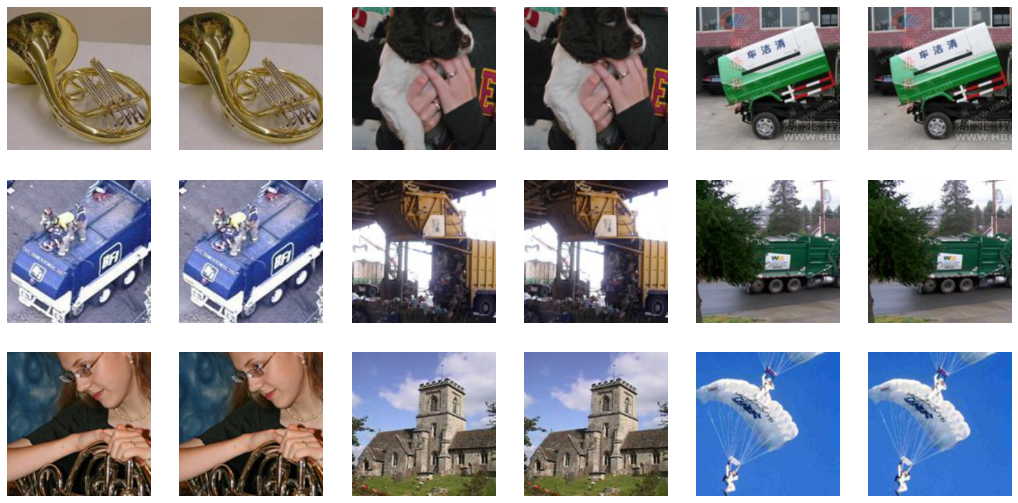

In [28]:
dls.show_batch()

In [29]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func) 

In [30]:
learn.fit_one_cycle(1, 1e-3)

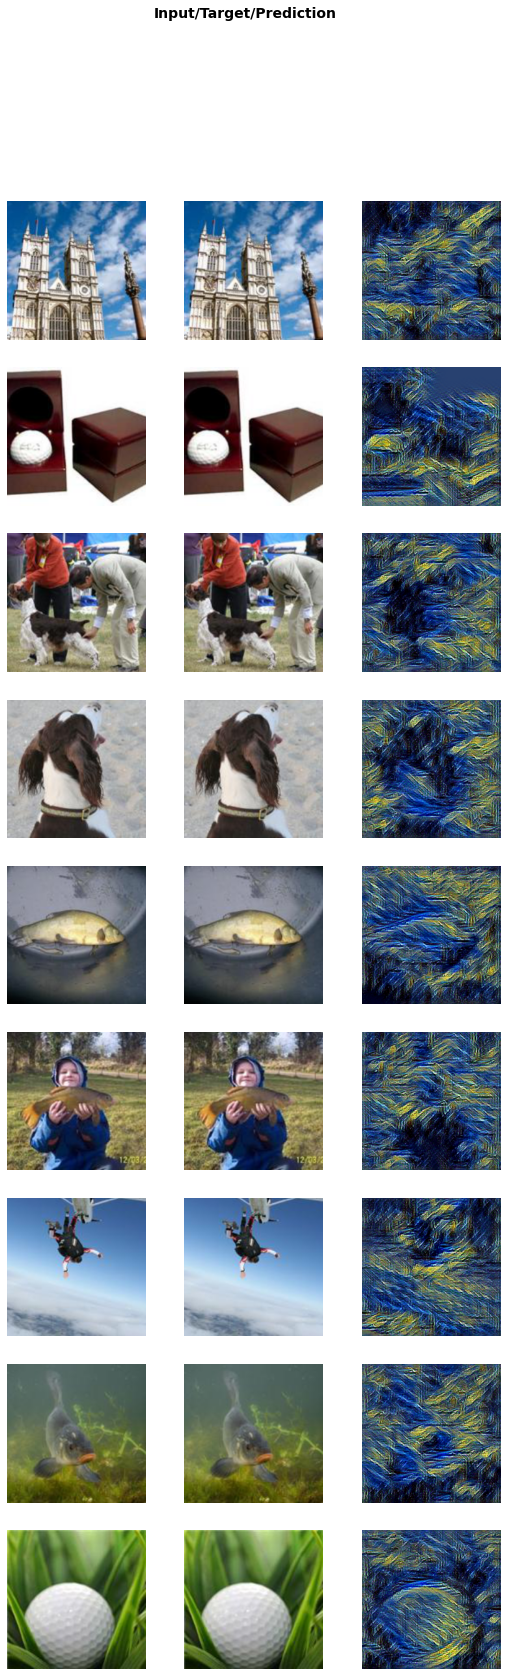

In [31]:
learn.show_results()

In [32]:
!gdown https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
!ls

Downloading...
From: https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
To: /content/11 BITS Pilani.jpg
100% 40.6k/40.6k [00:00<00:00, 6.58MB/s]
'11 BITS Pilani.jpg'   sample_data   style.jpg	 tmp


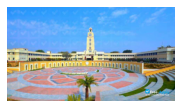

In [33]:
dset = Datasets('11 BITS Pilani.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
dl.show_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


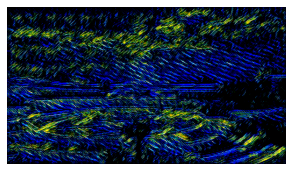

In [34]:
#predicting the Neural Style Transfered Image
t_im=dl.one_batch()[0]
with torch.no_grad():
    res=learn.model(t_im)
TensorImage(res[0]).show()

**Artist 2**

In [85]:
loss_net = vgg16(pretrained=True).features.cuda().eval()
loss_net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [86]:
for p in loss_net.parameters(): p.requires_grad=False

In [87]:
layers=[loss_net[i] for i in [1,6,11,20,29,22]]
layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [88]:
_vgg_config={
    'vgg16' : [1,6,11,20,29,22], #the authors proposed that these are the layer over which loss will be calculated
    'vgg19' : [1,6,11,20,29,22]}

In [89]:
acts = get_acts('vgg16')

In [90]:
url = 'https://i.pinimg.com/originals/8c/b9/00/8cb90084266a9f1c3aeb55c1bd937508.png'

In [91]:
def get_style_im(url):
  download_url(url, 'style4.jpg')
  fn = 'style4.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1) #need to convert image into a normalized, float tensor, otherwise GPU wont function properly
  return dl.one_batch()[0] #Pytorch expects all data to be in the form of DataLoaders.

In [92]:
style_im = get_style_im(url)
style_im.shape

torch.Size([1, 3, 1358, 2415])

In [93]:
im_acts=acts(style_im)
im_grams = [gram(f) for f in im_acts]

In [94]:
loss_func = PerceptualLoss(acts, style_loss, feat_loss)

In [95]:
net = TransformerNet()

In [96]:
path = untar_data(URLs.IMAGENETTE_160)

In [97]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [98]:
dls = dblock.dataloaders(path, bs=16)

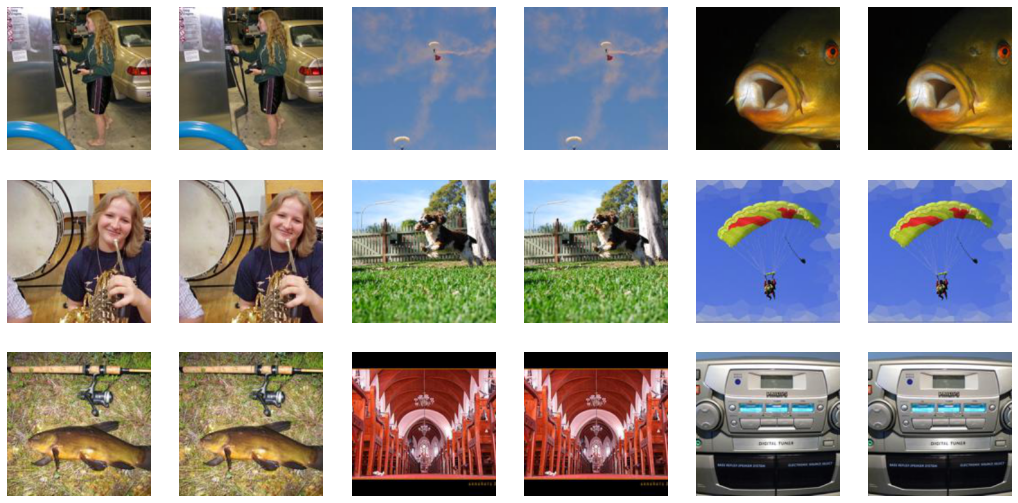

In [99]:
dls.show_batch()

In [100]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func) 

In [101]:
learn.fit_one_cycle(1, 1e-3)

In [102]:
learn.show_results()

In [103]:
!gdown https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
!ls

Downloading...
From: https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
To: /content/11 BITS Pilani.jpg
100% 40.6k/40.6k [00:00<00:00, 5.48MB/s]
'11 BITS Pilani.jpg'   sample_data   style2.jpg   style3.jpg   style.jpg   tmp


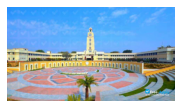

In [104]:
dset = Datasets('11 BITS Pilani.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
dl.show_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


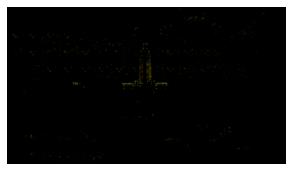

In [105]:
#predicting the Neural Style Transfered Image
t_im=dl.one_batch()[0]
with torch.no_grad():
    res=learn.model(t_im)
TensorImage(res[0]).show()

**Artist 3**

In [64]:
loss_net = vgg16(pretrained=True).features.cuda().eval()
loss_net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [65]:
for p in loss_net.parameters(): p.requires_grad=False

In [66]:
layers=[loss_net[i] for i in [1,6,11,20,29,22]]
layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [67]:
_vgg_config={
    'vgg16' : [1,6,11,20,29,22], #the authors proposed that these are the layer over which loss will be calculated
    'vgg19' : [1,6,11,20,29,22]}

In [68]:
acts = get_acts('vgg16')

In [69]:
url = 'https://d1drtiiz13sc9k.cloudfront.net/storyltd/2014/dec/husain_14stor_19839_tbig.jpg'

In [70]:
def get_style_im(url):
  download_url(url, 'style3.jpg')
  fn = 'style3.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1) #need to convert image into a normalized, float tensor, otherwise GPU wont function properly
  return dl.one_batch()[0] #Pytorch expects all data to be in the form of DataLoaders.

In [71]:
style_im = get_style_im(url)
style_im.shape

torch.Size([1, 3, 735, 1024])

In [72]:
im_acts=acts(style_im)
im_grams = [gram(f) for f in im_acts]

In [73]:
loss_func = PerceptualLoss(acts, style_loss, feat_loss)

In [74]:
net = TransformerNet()

In [75]:
path = untar_data(URLs.IMAGENETTE_160)

In [76]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [77]:
dls = dblock.dataloaders(path, bs=16)

In [78]:
dls.show_batch()

In [79]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func) 

In [80]:
learn.fit_one_cycle(1, 1e-3)

In [81]:
learn.show_results()

In [82]:
!gdown https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
!ls

Downloading...
From: https://drive.google.com/uc?id=1vNrb_BCyNs5xU95bZnNY5owcE97EUq_k
To: /content/11 BITS Pilani.jpg
100% 40.6k/40.6k [00:00<00:00, 5.93MB/s]
'11 BITS Pilani.jpg'   sample_data   style2.jpg   style3.jpg   style.jpg   tmp


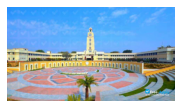

In [83]:
dset = Datasets('11 BITS Pilani.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
dl.show_batch()

In [84]:
#predicting the Neural Style Transfered Image
t_im=dl.one_batch()[0]
with torch.no_grad():
    res=learn.model(t_im)
TensorImage(res[0]).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
